# Table Detection

In [126]:
from huggingface_hub import hf_hub_download
from PIL import Image
import numpy as np
import os

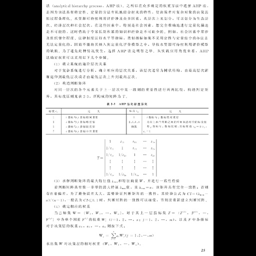

In [127]:
file_path = 'train_img/1_33.jpg'
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

In [128]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

c:\Users\debam\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\detr\feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


dict_keys(['pixel_values', 'pixel_mask'])

# Forward Pass

In [129]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

In [130]:
import torch

with torch.no_grad():
    outputs = model(**encoding)

In [131]:
import matplotlib.pyplot as plt

COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca() 
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [132]:
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

In [133]:
results

{'scores': tensor([0.9981]),
 'labels': tensor([0]),
 'boxes': tensor([[ 96.6380, 219.7242, 412.0294, 269.0876]])}

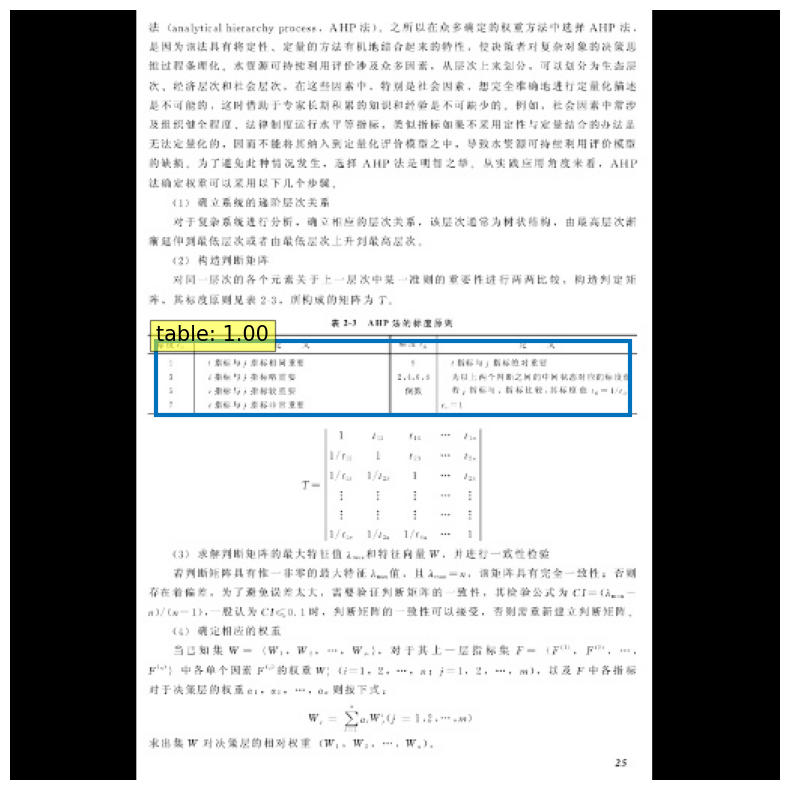

In [134]:
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [135]:
import matplotlib.patches as patches


def plot_results_updated(pil_img, scores, labels, boxes):
    plt.rcParams['axes.facecolor'] = 'white'
    img_array = np.array(pil_img)  # Convert PIL image to NumPy array
    plt.figure(figsize=(16, 10))
    ax = plt.gca()
    ax.imshow(img_array)
    

    for score, label, (xmin, ymin, xmax, ymax) in zip(scores.tolist(), labels.tolist(), boxes.tolist()):
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=3, edgecolor='black', facecolor='black')
        ax.add_patch(rect)

    ax.axis('off')
    ax.set_xlim([0, img_array.shape[1]])  # Set the x-axis limits
    ax.set_ylim([img_array.shape[0], 0])  # Set the y-axis limits
    ax.set_facecolor('white')  # Set the background color to white
    
    plt.show()


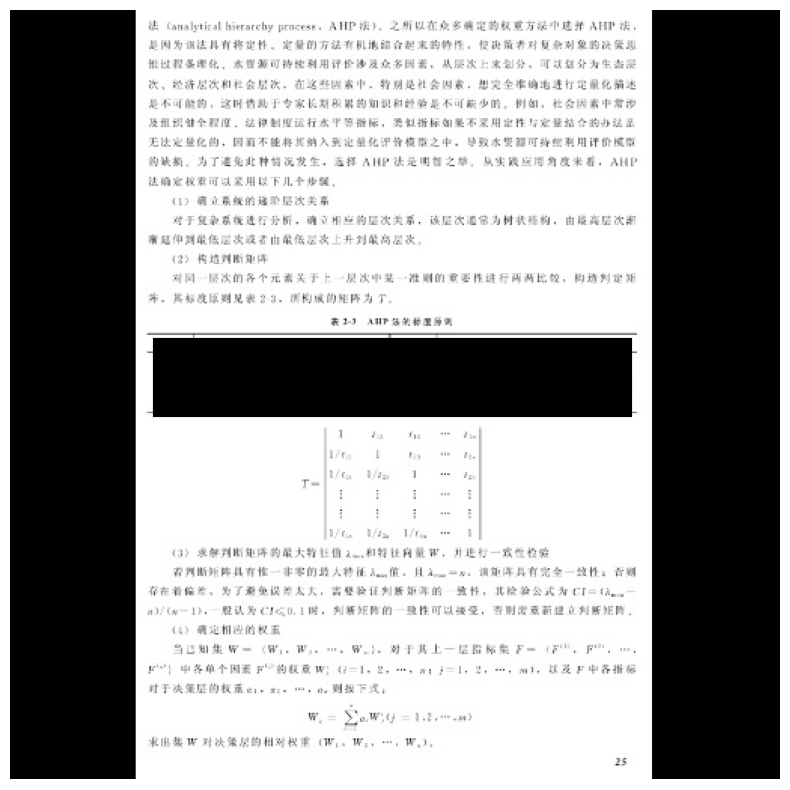

In [136]:
plot_results_updated(image, results['scores'], results['labels'], results['boxes'])

In [137]:
def IoUScore(predicted_array, ground_truth_array):
    intersection = np.logical_and(predicted_array, ground_truth_array)
    union = np.logical_or(predicted_array,ground_truth_array)

    intersection_area = np.sum(intersection)
    union_area = np.sum(union)

    if union_area==0:
        return 0
    else :
        return intersection_area/union_area

In [138]:
predicted_array = np.array([[0, 1, 1, 0],
                            [1, 1, 1, 1],
                            [0, 0, 1, 1]])

ground_truth_array = np.array([[0, 1, 0, 0],
                               [1, 1, 1, 1],
                               [0, 0, 1, 1]])

iou_score = IoUScore(predicted_array, ground_truth_array)
print("IoU Score:", iou_score)

IoU Score: 0.875


In [139]:
from sklearn.metrics import accuracy_score
# Define evaluation metrics
y_true = []  # Ground truth labels
y_pred = []  # Predicted labels
counter = 0
dataset_path = "train_img"
masked_dataset_path = "png_ano_train"
detection_threshold = 0.7
for file_name in os.listdir(dataset_path):
    y_true = []  # Ground truth labels
    y_pred = []  # Predicted labels
    if counter>=1:
        break 
    # Load the dataset image (JPG)
    image_path = os.path.join(dataset_path, file_name)
    image = Image.open(image_path).convert("RGB")
    
    # Load the corresponding masked image (PNG)
    masked_image_path = os.path.join(masked_dataset_path, file_name[:-4] + ".png")  # Assuming the filenames are consistent
    masked_image = Image.open(masked_image_path)
    
    # Preprocess the dataset image
    width, height = image.size
    encoding = feature_extractor(image, return_tensors="pt")
    
    # Perform table detection
    with torch.no_grad():
        outputs = model(**encoding)
    
    # Post-process the detection results
    width, height = image.size
    results = feature_extractor.post_process_object_detection(outputs, threshold=detection_threshold, target_sizes=[(height, width)])[0]
    
    # Convert the results to binary masks
    pred_mask = np.zeros((height, width), dtype=np.uint8)
    for box in results['boxes']:
        xmin, ymin, xmax, ymax = box.tolist()
        xmin, xmax = int(xmin), int(xmax)
        ymin, ymax = int(ymin), int(ymax)
        pred_mask[ymin:ymax, xmin:xmax] = 1
    
    
    # Convert the masked image to binary mask
    true_mask = np.array(masked_image)
    true_mask = true_mask*255
    temp_data = Image.fromarray(true_mask).convert("L")
    true_mask = np.array(temp_data)
    true_mask = np.where(true_mask == 0, 1, 0)
    # Compare the binary masks
    print(true_mask.sum())
    print(pred_mask.sum())
    y_true.extend(true_mask.flatten())
    y_pred.extend(pred_mask.flatten())
    
    # if counter%100 == 0:
    #     print(counter," images done....") 
    accuracy = accuracy_score(y_true, y_pred)
    
    print(accuracy)
    counter += 1

3570
3069
0.9973793029785156


In [143]:
from PIL import Image
import sys
np.set_printoptions(threshold=sys.maxsize)
# Load the RGB image
rgb_image = Image.open('png_ano_train/1_33.png')
array = np.array(rgb_image)
array = array*255
data = Image.fromarray(array).convert("L")
data_array = np.array(data)
manipulated_arr = np.where(data_array == 0, 1, 0)
manipulated_arr.sum()


17658

# Table Structure Recognition

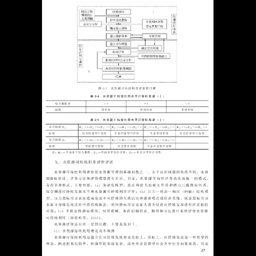

In [196]:
from huggingface_hub import hf_hub_download
from PIL import Image

file_path = 'test_img/1_35.jpg'
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

In [197]:
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [198]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")
     


In [199]:
with torch.no_grad():
  outputs = model(**encoding)

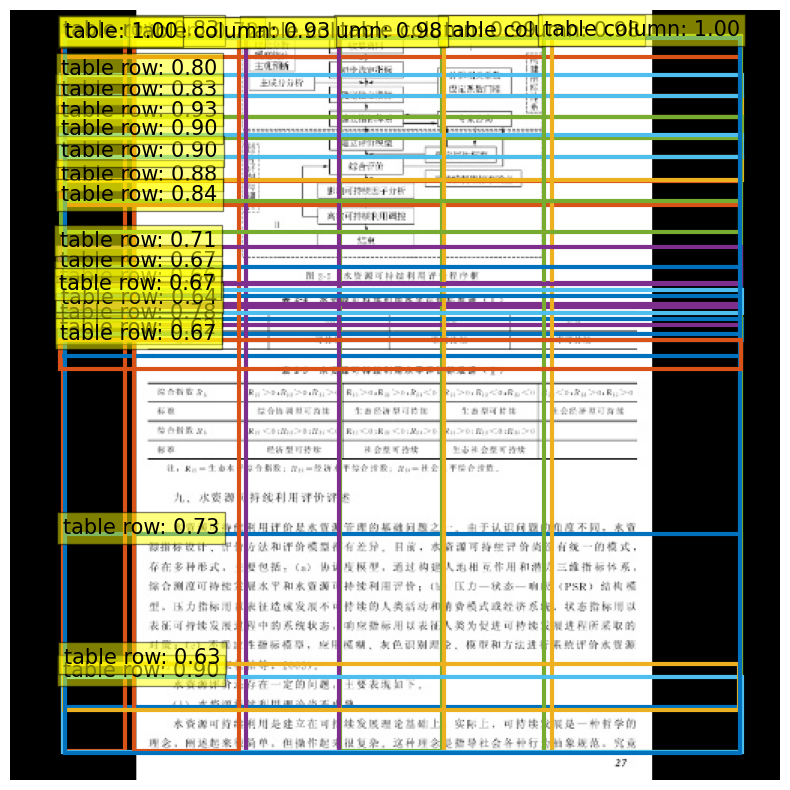

In [200]:
target_sizes = [image.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])
     

In [201]:
model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}